<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

# O cenário da cidade do Rio de Janeiro: Distribuição inicial de Infectados

- Continuando a criação de cenários que sejam **múltiplos** do cenário `Pop350` visto anteriormente.

- Neste segundo caderno da série, ...

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy import stats
import pandas as pd

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
import episiming

## Criando o cenário do Rio com redução

In [3]:
tx_reducao = 100
landscan_file = '../../../../dados/RJ/cidade_rj/dados_estatisticos/LandScan.npy'
piramide_file = 'piramide_etaria_MRJ.csv'
escolas_file = 'municipais.npy'
cenario_rio = episiming.cenarios.RiodeJaneiro(tx_reducao, landscan_file, piramide_file, escolas_file)
print(f'População do cenário reduzido: {cenario_rio.num_pop}\n')

População do cenário reduzido: 67973



### População do Rio de Janeiro

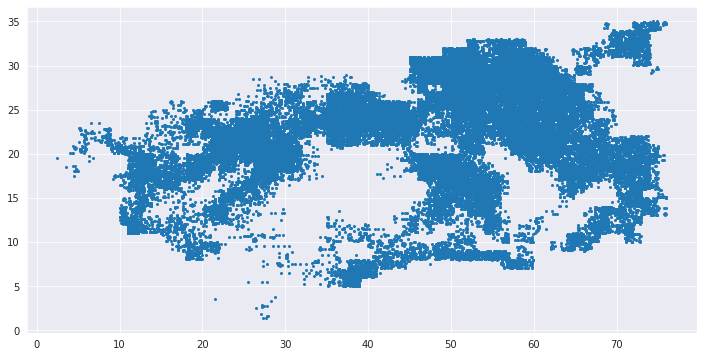

In [4]:
x, y = cenario_rio.pop_posicoes.T
plt.figure(figsize=(12,6))
plt.scatter(x, y, s=4)
plt.show()

### Carregando matriz com a relação dos bairros nos blocos

In [5]:
mtrx_bairros = np.load('geoloc_Bairros_MRJ.npy')

### Carregando matriz com infectados por blocos. Dados de 15/06/2020

In [6]:
mtrx_infectados = np.load('infectados.npy')

## Tratamento da subnotificação

In [7]:
def corrige_subnotificacao(mtrx_infectaos):
    return mtrx_infectados*8

## Redução dos casos de infectados de acordo com `tx_reducao`

In [8]:
def reducao_mtrx(tx_reducao, mtrx):
    if tx_reducao == 1:
        mtrx_reduzida = mtrx
    else:
        qt_total = np.rint(np.sum(mtrx)/tx_reducao)
        rng_blocos = np.arange(np.prod(np.shape(mtrx)))
        pesos = (mtrx/np.sum(mtrx)).flatten()
        escolha = np.array(random.choices(rng_blocos, pesos, k = int(qt_total)))

        rows = np.floor(escolha/83)
        cols = np.mod(escolha,83)
        mtrx_reduzida = np.zeros((39,83))
        for i,j in zip(rows,cols):
            mtrx_reduzida[int(i)][j] += 1
    return mtrx_reduzida

As posições da população são dadas com o eixo `y` em ordem diferente das matrizes de blocos, aqui fazemos uma troca de linhas 

In [9]:
def corrige_mtrx(mtrx):
        new_mtrx = np.zeros(np.shape(mtrx))
        for i in range(39):
            new_mtrx[np.abs(i-38)] = mtrx[i]
        return new_mtrx

In [29]:
mtrx_bairros_corrigida = corrige_mtrx(mtrx_bairros)

## Distribue os casos nos blocos

O output desta função é uma lista com o indíce dos indivíduos que terão `estado = 2`, ou seja, infectados

Como input temos:

- `tx_reducao`: Taxa de redução do cenário
- `mtrx_casos`: Matriz com os casos de infectados por bloco
- `pop_posicoes`: Posição da população, quando implementado em `episiming` este parametro some e é usado `self.pop_posicoes`


In [10]:
def distribuicao_inicial_casos(tx_reducao, mtrx_casos, pop_posicoes):
    mtrx_casos = corrige_mtrx(mtrx_casos)

    pos_indv_blocos = np.round(pop_posicoes)
    mtrx_casos_reduzida = reducao_mtrx(tx_reducao, mtrx_casos)

    casos = []
    rng = np.arange(len(pos_indv_blocos))
    for x in range(83):
        for y in range(39):
            checa_bloco_indv = pos_indv_blocos == [x,y]
            indv_nos_blocos =  np.logical_and(checa_bloco_indv[:,0], checa_bloco_indv[:,1])
            indices_no_bloco = rng[indv_nos_blocos]
            qt_bloco = mtrx_casos_reduzida[y,x]                  
            if (qt_bloco > 0) & (len(indices_no_bloco) > 0):
                indv_casos = np.random.choice(indices_no_bloco, int(qt_bloco))
                for e in indv_casos:
                    casos.append(e)
    return casos

## Verificando a distribuição

Para verificar se a distribuição dos infectados está ocorrendo de acordo com o que se espera, vamos distribuir os casos de infectados diagnosticados na cidade do Rio de Janeiro e comparar com a tabela da prefeitura

---
### Casos de infectados diagnosticados - 15/06/2020

As células a seguir trazem funções que dizem respeito somente ao tratamento dos arquivos `.csv` da prefeitura e não tem efeito prático na distribuição dos casos

In [11]:
import yaml

In [12]:
with open('config.yml', encoding = 'utf-8') as f:
    configs = yaml.load(f, Loader = yaml.FullLoader)
    
with open('bairros.yml', encoding = 'utf-8') as f:
    ids = yaml.load(f, Loader = yaml.FullLoader)

In [14]:
def set_df(df_file, **kwargs):
    """Carrega o CSV com dados do covid para determinada cidade ou estado e retorna um pandas.DataFrame com os dados

    Parameters
    ----------
    fonte : str ('prefeitura_rj', 'estado_rj')
        Indica qual a fonte dos dados, com isso a função determina qual CSV carregar e como tratar o DataFrame.
        O arquivo a ser carregado é dado em configs.yml
    *args : dict, optional
        Um dicionário com argumentos extras:
            df_break: Se setado para True, muda o retorno para vários DataFrames
    Returns
    -------
    ret_v: Se nenhum argumento opcional for passado, ret_v é uma lista contendo o DataFrame tratado com todos os casos, e a data de atualização dos dados
            df_break == True: ret_v é uma lista com [DataFrame Tratado, [DataFrame Ativos, DataFrame Recuperados, DataFrame Obitos], Data de Atualização]        
    """

    df = pd.read_csv(df_file, encoding = 'iso-8859-1', delimiter = ';')
    df.rename(columns = configs['df']['rename']['rj']['colunas']['prefeitura'], inplace = True)
    dt_att = df['Data_atualização'].values[0]
    for drop in configs['df']['droppable']['rj']['prefeitura']:
        df.drop(drop, axis = 1, inplace = True)
    for r in configs['df']['rename']['rj']['dados']['prefeitura']:
        df[r].replace(configs['df']['rename']['rj']['dados']['prefeitura'][r], inplace = True)
    if 'df_break' in kwargs  and kwargs['df_break'] == True:
        df_break = []
        for s in configs['df']['status']['rj']['prefeitura']:
            df_break.append(df[df['Evolucao'] == s])
        ret_lst = [df, df_break, dt_att]
    else:
        ret_lst = [df, dt_att]
    return ret_lst

In [22]:
def conta_infectados_bairros(infectados, mtrx_bairros):
    pos_blocos_infectados = np.round(cenario_rio.pop_posicoes[infectados])
    ids_bairros = [mtrx_bairros[int(i[1]),int(i[0])] for i in pos_blocos_infectados]
    bairros_count = {}
    for i in set(ids_bairros):
        bairros_count.update({int(i): ids_bairros.count(i)})
    return bairros_count

def count_estado_bairro(df,ids, infectados, mtrx_bairros):
    n = [0]
    infect_por_bairro = conta_infectados_bairros(infectados, mtrx_bairros)
    for i in range(1,164):
        if i in infect_por_bairro.keys():
            n.append([len(df[df['Bairro'] == ids[i]]), infect_por_bairro[i]])
        else:
            n.append([len(df[df['Bairro'] == ids[i]]), 0])
    dic = {ids[i]: n[i] for i in range(1,164)}
    indef = len(df[df['Bairro'] == 'INDEFINIDO'])
    return dic, indef

Fim das funções para os dataframes

---

In [18]:
df = set_df('Dados_indiv_MRJ_covid_19.csv', df_break = True)
df_atv = df[1][0] ## DataFrame de casos Ativos

In [21]:
df_atv

,Data,DataSintomas,Bairro,AP,Sexo,FaixaEtaria,Evolucao,dt_óbito,raça/cor
5201,04/06/2020,01/06/2020,SENADOR CAMARA,5.1,M,De 50 a 59,Ativo,NaN,Branca
5220,04/06/2020,03/06/2020,JACAREPAGUA,4.0,F,De 90 a 100,Ativo,NaN,Branca
5256,05/06/2020,02/06/2020,BANGU,5.1,M,De 60 a 69,Ativo,NaN,Ignorado
5338,04/06/2020,02/06/2020,PADRE MIGUEL,5.1,M,De 40 a 49,Ativo,NaN,Ignorado
5454,06/04/2020,02/04/2020,DEODORO,5.1,F,De 60 a 69,Ativo,NaN,Branca
...,...,...,...,...,...,...,...,...,...
42245,12/06/2020,01/06/2020,INDEFINIDO,N/D,F,De 30 a 39,Ativo,NaN,Preta
42340,10/06/2020,01/06/2020,BANGU,5.1,M,De 30 a 39,Ativo,NaN,Parda
42354,14/06/2020,15/03/2020,LAGOA,2.1,M,De 80 a 89,Ativo,NaN,Ignorado
42377,14/06/2020,12/06/2020,FORA DO MUNICÍPIO,N/D,F,De 30 a 39,Ativo,NaN,Ignorado


In [27]:
# Distribuicao dos diagnosticados
diagnosticados = distribuicao_inicial_casos(1, mtrx_infectados, cenario_rio.pop_posicoes)

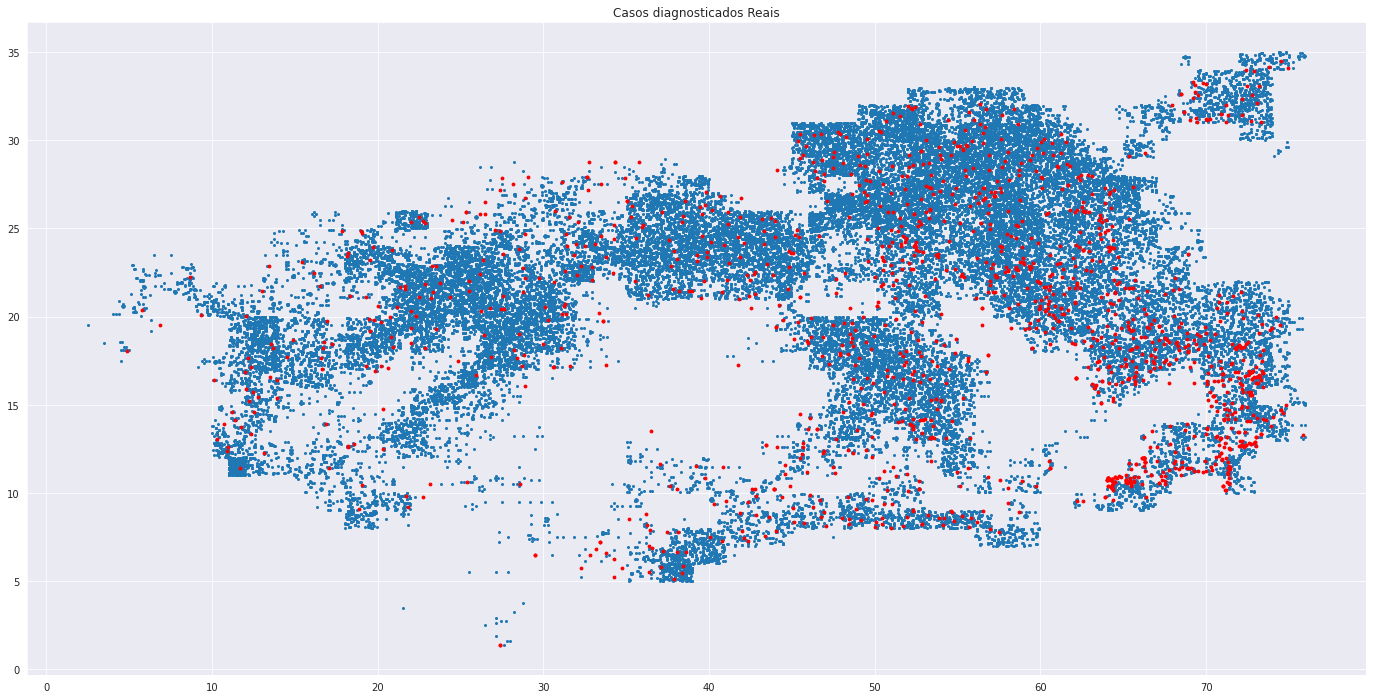

In [60]:
x, y = cenario_rio.pop_posicoes.T
x_inf, y_inf = cenario_rio.pop_posicoes[diagnosticados].T
plt.figure(figsize=(24,12))
plt.scatter(x, y, s=4)
plt.scatter(x_inf, y_inf, s=8, color = 'red')
plt.title('Casos diagnosticados Reais')
plt.show()

In [72]:
qt_fora = len(df_atv[df_atv['Bairro'] == 'FORA DO MUNICÍPIO'])

In [74]:
print(f'Existem {qt_fora} casos fora do município, então esperamos distribuir no total: {len(df_atv) - qt_fora} infectados')

Existem 21 casos fora do município, então esperamos distribuir no total: 1521 infectados


In [75]:
print(f'Foram distribuidos {len(diagnosticados)} casos, esse defasagem pode estar ocorrendo por conta da diferença de localização dos individuos com os blocos')

Foram distribuidos 1432 casos, esse defasagem pode estar ocorrendo por conta da diferença de localização dos individuos com os blocos


## Plot da posição da população com o mapa do Rio de Janeiro

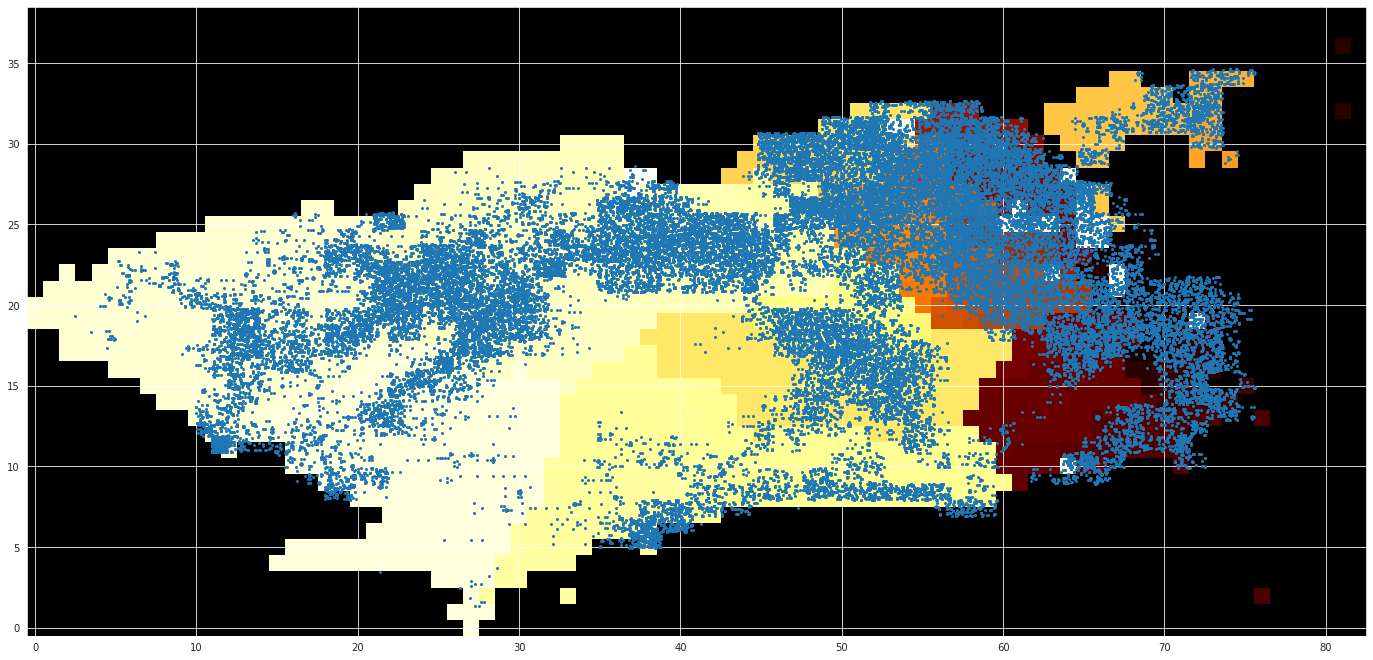

In [138]:
x, y = cenario_rio.pop_posicoes.T
plt.figure(figsize=(24,12))
plt.scatter(x*0.995, y*0.99, s=4)
plt.scatter(cenario_rio.pop_posicoes[12643][0], cenario_rio.pop_posicoes[12643][1], color = 'red', s= 4)
plt.imshow(mtrx_bairros_corrigida, cmap = 'afmhot')
plt.gca().invert_yaxis()
plt.show()

In [30]:
# Faz a contagem dos casos nos bairros pelo DataFrame da prefeitura e pela distribuição
dic_infectados, n_indef = count_estado_bairro(df_atv, ids['id_bairros'], diagnosticados, mtrx_bairros_corrigida)

In [32]:
## Traz um dicionario Nome: [P, D] - P -> Quantidade dos dados da prefeitura, D -> Quantidade distribuida
dic_infectados

{'SAUDE': [2, 2],
 'GAMBOA': [4, 4],
 'SANTO CRISTO': [0, 0],
 'CAJU': [1, 1],
 'CENTRO': [10, 10],
 'CATUMBI': [7, 7],
 'RIO COMPRIDO': [8, 8],
 'CIDADE NOVA': [0, 0],
 'ESTACIO': [8, 8],
 'SAO CRISTOVAO': [10, 10],
 'MANGUEIRA': [3, 3],
 'BENFICA': [7, 7],
 'PAQUETA': [0, 0],
 'SANTA TERESA': [4, 3],
 'FLAMENGO': [28, 28],
 'GLORIA': [3, 4],
 'LARANJEIRAS': [16, 16],
 'CATETE': [12, 12],
 'COSME VELHO': [4, 5],
 'BOTAFOGO': [30, 30],
 'HUMAITA': [3, 3],
 'URCA': [7, 7],
 'LEME': [1, 1],
 'COPACABANA': [58, 58],
 'IPANEMA': [20, 15],
 'LEBLON': [20, 20],
 'LAGOA': [10, 10],
 'JARDIM BOTANICO': [5, 5],
 'GAVEA': [53, 53],
 'VIDIGAL': [2, 2],
 'SAO CONRADO': [11, 6],
 'PRACA DA BANDEIRA': [6, 6],
 'TIJUCA': [60, 60],
 'ALTO DA BOA VISTA': [3, 4],
 'MARACANA': [11, 11],
 'VILA ISABEL': [13, 13],
 'ANDARAI': [10, 10],
 'GRAJAU': [11, 4],
 'MANGUINHOS': [4, 4],
 'BONSUCESSO': [17, 17],
 'RAMOS': [14, 14],
 'OLARIA': [10, 11],
 'PENHA': [10, 10],
 'PENHA CIRCULAR': [10, 10],
 'BRAS DE PINA'

In [33]:
## Extraindo os dados do dicionario
diagn_df = np.array(list(dic_infectados.values()))[:,0]
diagn_mtrx = np.array(list(dic_infectados.values()))[:,1]

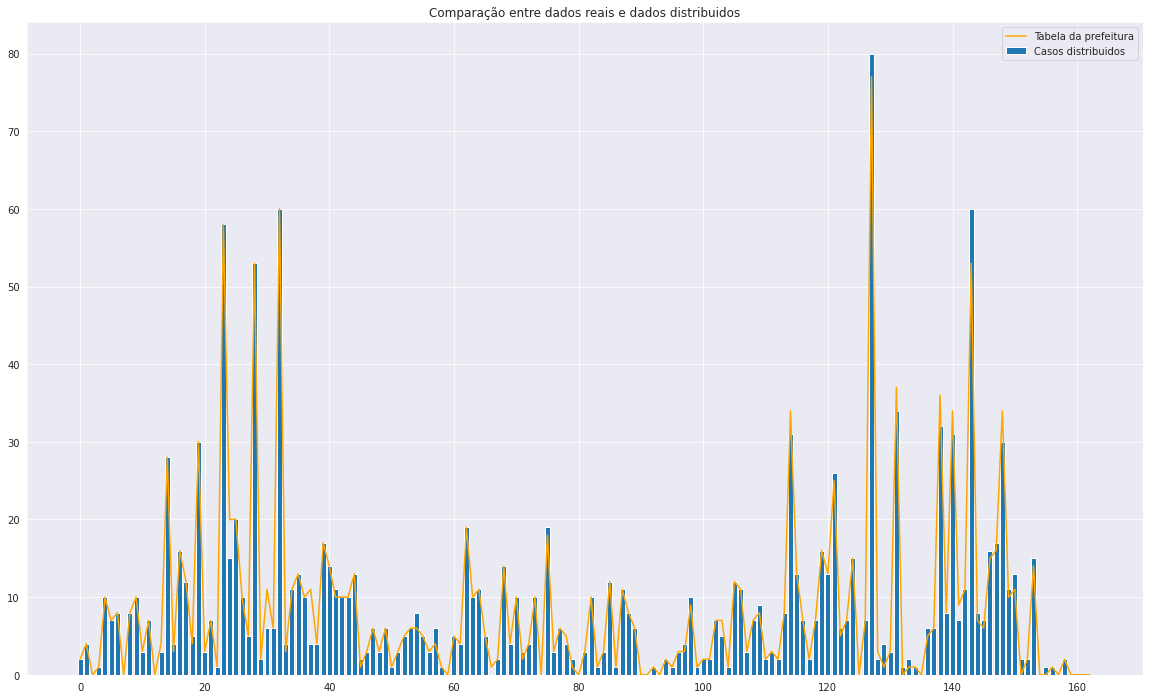

In [39]:
plt.figure(figsize = (20,12))

plt.plot(range(len(diagn_df)), diagn_df, color = 'orange', label = 'Tabela da prefeitura')
plt.bar(range(len(dic_infectados)), diagn_mtrx, align='center', label = 'Casos distribuidos')
plt.legend()
plt.title('Comparação entre dados reais e dados distribuidos')
plt.show()

In [77]:
len(df_atv[df_atv['Bairro'] == 'INDEFINIDO'])

91

Podemos ver que a distribuição dos casos está de acordo com a distribuição real dos dados, ou seja, o que esperamos.
Algumas diferenças entre os dois gráficos acontecem também por conta de existirem `91` casos com bairros indefinidos, que não entram no gráfico da tabela da prefeitura, mas entram distribuidos nos casos ativos

---

## Incluindo a subnotificação nos infectados

### Caso sem redução de população

In [148]:
mtrx_infectados_real = corrige_subnotificacao(mtrx_infectados)

In [156]:
%%timeit
infectados_0 = distribuicao_inicial_casos(1, mtrx_infectados_real, cenario_rio.pop_posicoes)

1.1 s ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [150]:
total_infectados = np.sum(mtrx_infectados_real)

In [151]:
print(f'Total esperado de Infectados dada a redução: {total_infectados}, Casos distribuidos: {len(infectados_0)}')

Total esperado de Infectados dada a redução: 12168.0, Casos distribuidos: 11456


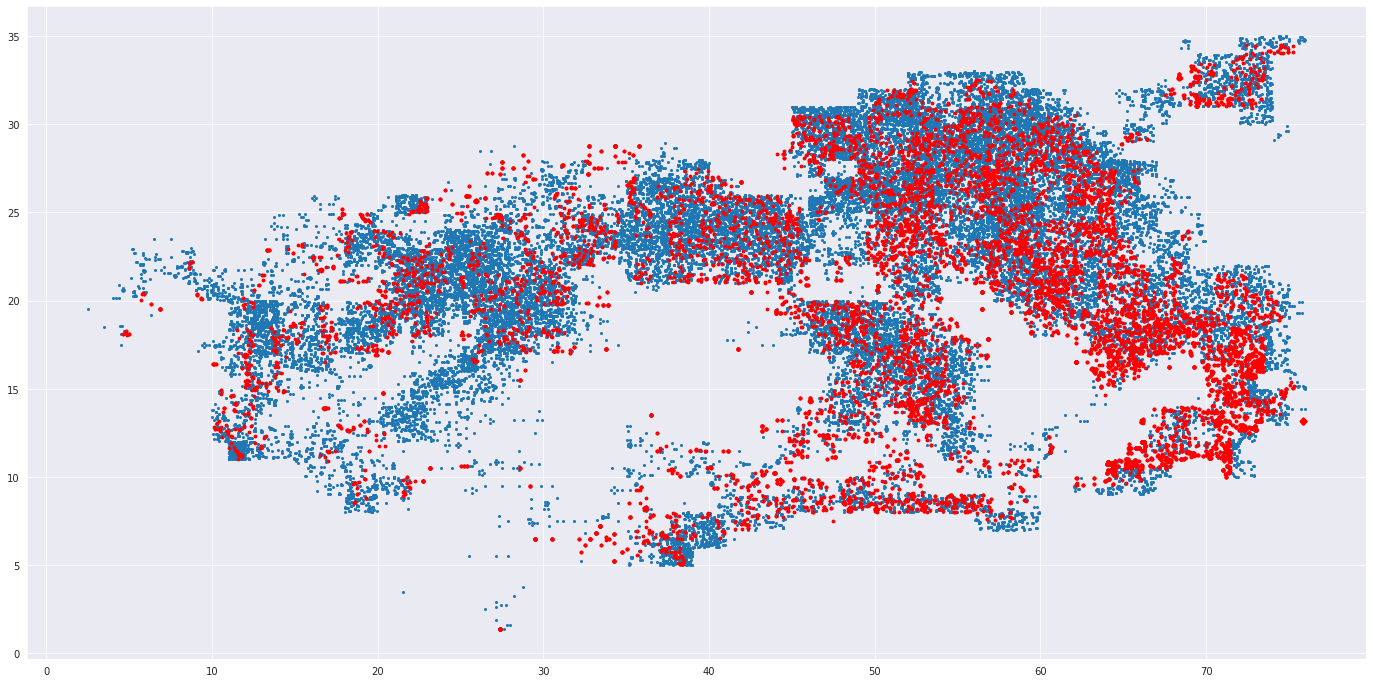

In [152]:
x, y = cenario_rio.pop_posicoes.T
x_inf, y_inf = cenario_rio.pop_posicoes[infectados_0].T
plt.figure(figsize=(24,12))
plt.scatter(x, y, s=4)
plt.scatter(x_inf, y_inf, s=8, color = 'red')
plt.show()

### Caso com a redução da população

In [157]:
%%timeit
infectados_0 = distribuicao_inicial_casos(tx_reducao, mtrx_infectados_real, cenario_rio.pop_posicoes)

1.09 s ± 28.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [154]:
print(f'Total esperado de Infectados dada a redução: {np.rint(total_infectados/tx_reducao)}, Casos distribuidos: {len(infectados_0)}')

Total esperado de Infectados dada a redução: 122.0, Casos distribuidos: 115


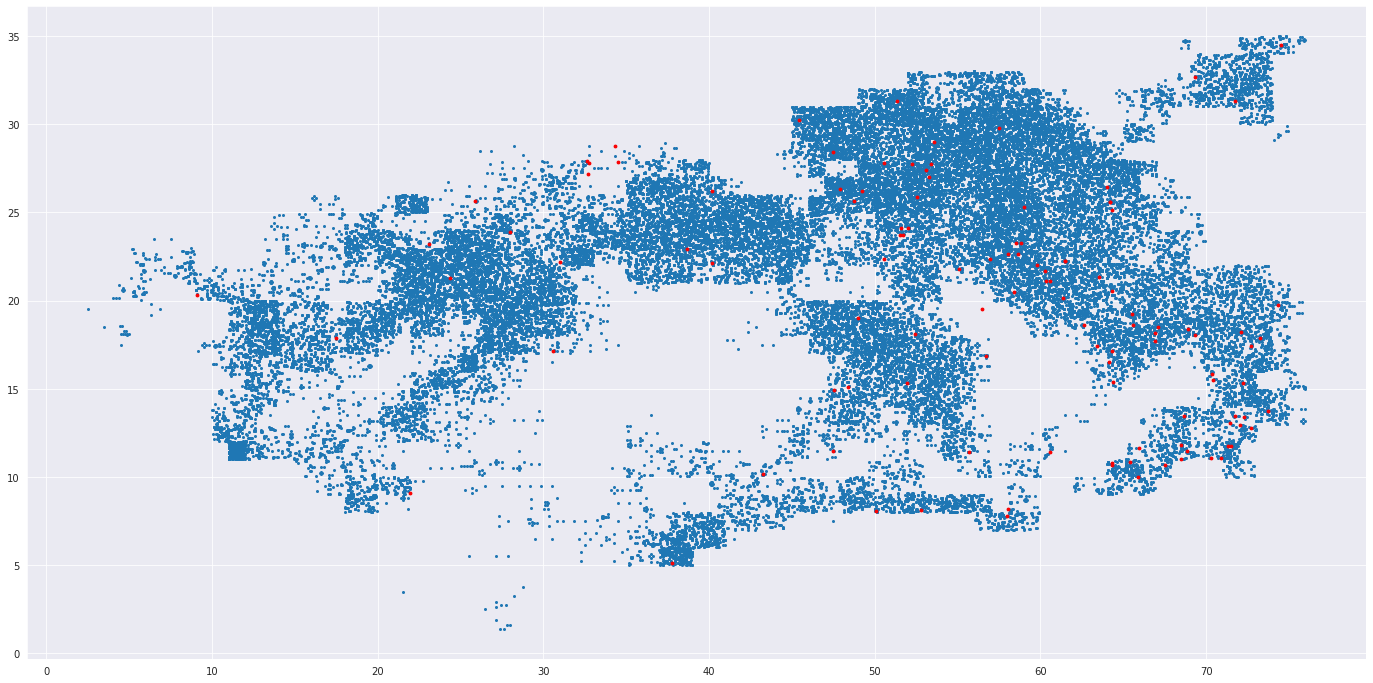

In [155]:
x, y = cenario_rio.pop_posicoes.T
x_inf, y_inf = cenario_rio.pop_posicoes[infectados_0].T
plt.figure(figsize=(24,12))
plt.scatter(x, y, s=4)
plt.scatter(x_inf, y_inf, s=8, color = 'red')
plt.show()

# Inicializando Infecção em 16/05

In [82]:
mtrx_infect_1605 = np.load('infectados_1605.npy')

In [83]:
mtrx_infect_1605_real = corrige_subnotificacao(mtrx_infect_1605)

In [84]:
infectados_1605_0 = distribuicao_inicial_casos(tx_reducao, mtrx_infect_1605_real, cenario_rio.pop_posicoes)

In [86]:
print(f'Casos distribuidos: {len(infectados_1605_0)}, número de casos esperados {np.rint(np.sum(mtrx_infect_1605_real)/tx_reducao)}')

Casos distribuidos: 118, número de casos esperados 122.0


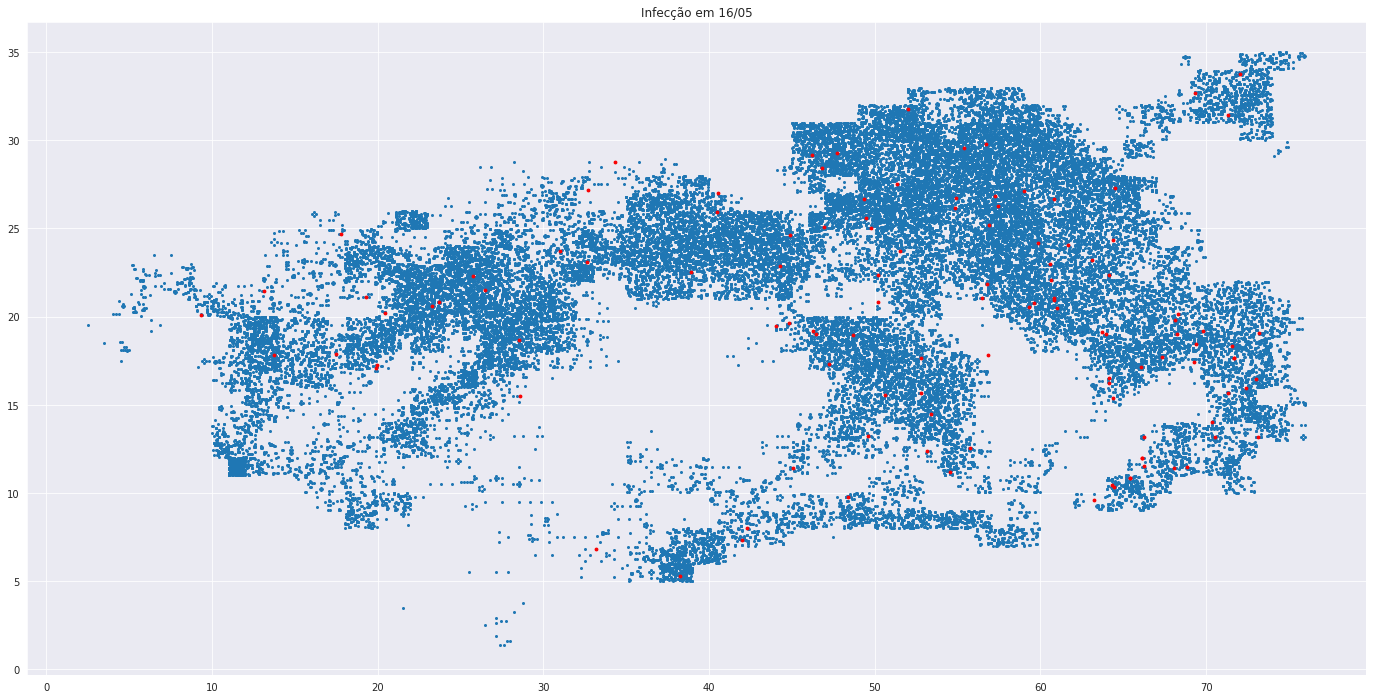

In [87]:
x, y = cenario_rio.pop_posicoes.T
x_inf, y_inf = cenario_rio.pop_posicoes[infectados_1605_0].T
plt.figure(figsize=(24,12))
plt.scatter(x, y, s=4)
plt.scatter(x_inf, y_inf, s=8, color = 'red')
plt.title('Infecção em 16/05')
plt.show()

Como o output da função `distribuicao_inicial_casos` é uma lista de indices dos individuos infectados, podemos facilmente implementar a função no módulo `episiming`, alterando apenas a linha do `infectados_0`

In [93]:
infectados_0

[61188,
 59709,
 58304,
 62804,
 64408,
 44087,
 32004,
 36944,
 41519,
 32803,
 52651,
 41635,
 67044,
 11432,
 67047,
 67656,
 37865,
 66600,
 37828,
 14960,
 15001,
 14987,
 23616,
 64647,
 66749,
 63784,
 61512,
 29456,
 34181,
 29542,
 8751,
 5897,
 62928,
 6068,
 65650,
 57299,
 52908,
 49403,
 52940,
 29781,
 63842,
 38359,
 50048,
 25024,
 24964,
 29823,
 20502,
 6854,
 66144,
 56019,
 16500,
 63903,
 53626,
 25366,
 21086,
 16895,
 30508,
 21166,
 7684,
 42322,
 42413,
 35415,
 17336,
 46273,
 46523,
 17532,
 30976,
 64033,
 65014,
 64043,
 64008,
 50254,
 50326,
 50442,
 17750,
 2521,
 64096,
 63172,
 50383,
 64150,
 64201,
 63191,
 50555,
 46696,
 42860,
 63208,
 46781,
 63238,
 64258,
 50878,
 50834,
 50867,
 51031,
 46933,
 969,
 198,
 212,
 63403,
 63437,
 63425,
 61971,
 61949,
 59305,
 58090,
 54379,
 2840,
 59479,
 58159,
 58064,
 54343,
 51218,
 62020,
 56592,
 56509,
 56526,
 56559,
 5814]

In [88]:
def inicializa_pop_estado(self):
        np.random.seed(seed = 342)
        #self.pop_estado_0 = np.ones(num_pop, dtype=np.uint8)
        self.pop_estado_0 = np.ones(self.num_pop)
        infectados_0 = distribuicao_inicial_casos(tx_reducao, mtrx_infect, cenario_rio.pop_posicoes)
        #self.pop_estado_0[infectados_0] = \
        #    2*np.ones(num_infectados_0, dtype=np.uint8)
        self.pop_estado_0[infectados_0] = 2*np.ones(self.num_infectados_0)
        self.attr_estado_0 = dict([(i, {'estado': int(self.pop_estado_0[i])}) 
                                   for i in range(self.num_pop)])

---
# O problema da defasagem na posição dos indivíduos e blocos

In [139]:
pos_indv_blocos = np.round(cenario_rio.pop_posicoes*[0.995,0.99])

In [140]:
status = []
rng = np.arange(len(pos_indv_blocos))
for x in range(83):
    for y in range(39):
        checa_bloco_indv = pos_indv_blocos == [x,y]
        indv_nos_blocos = np.logical_and(checa_bloco_indv[:,0], checa_bloco_indv[:,1])
        indices_no_bloco = rng[indv_nos_blocos]
        id_bloco = mtrx_bairros_corrigida[y,x]
        if id_bloco == 0 and len(indices_no_bloco) > 0:
            status.append([x,y, indices_no_bloco, len(indices_no_bloco)])

In [141]:
status = np.array(status)

In [142]:
np.sum(status[:,3]), cenario_rio.num_pop, np.sum(status[:,3])/cenario_rio.num_pop * 100

(2110, 67973, 3.1041737160343077)